## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

### Постановка задачи<a class="anchor" id="course_project_task"></a>
**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

## Построение модели классификации
### 1. Обзор обучающего датасета
**Подключение библиотек и скриптов**

In [1]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import lightgbm as lgbm, catboost as catb

import xgboost as xgb

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams.update({'font.size': 12})

import warnings
warnings.simplefilter('ignore')

**Пути к директориям и файлам**

In [2]:
TRAIN_PATH = './course_project/course_project_train.csv'
TEST_PATH = './course_project/course_project_test.csv'
MODEL_FILE_PATH = './course_project/teach_model.pkl'

**Загрузка данных**

In [3]:
df_train_before_prep = pd.read_csv(TRAIN_PATH)
df_test_before_prep = pd.read_csv(TEST_PATH)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [4]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    report = {'train_report': classification_report(y_train_true, y_train_pred), 
              'test_report':classification_report(y_test_true, y_test_pred),
              'crosstab': pd.crosstab(y_test_true, y_test_pred)}
    return report 

In [5]:
class DataPreparation:
    def __init__(self, path_to_file):
        self.current_loan_amount_median = 0
        self.add_dummies_columns = None
        self.df = pd.read_csv(path_to_file)
        
    def get_loan_amount_median(self):
        return self.df[self.df['Current Loan Amount'] <= 9999999.0]['Current Loan Amount'].median()
                       
    def get_default_annual_income(self):
        a_i = self.df[self.df['Annual Income'] != 0]['Annual Income']
        return (2 * a_i.mean() + 3 * a_i.min())/5
    
    def transform(self, current_loan_amount_median, default_annual_income):
        df = self.df.copy()
        add_dummies_columns = None

        YICJ_to_numbers = {'< 1 year':'0',
                            '1 year':'1','2 years':'1','3 years':'1','4 years':'1','5 years':'2', 
                            '6 years':'2','7 years':'2','8 years':'3','9 years':'3',
                            'Years in current job_10+ years':'3'}

        df['Years in current job'] = df['Years in current job'].map(YICJ_to_numbers)

        df.loc[(df['Purpose'] == 'debt consolidation'), 'Purpose'] = 0
        df.loc[df['Purpose']!=0, 'Purpose'] = 1
        
        df.loc[df['Maximum Open Credit'] > np.quantile(df['Maximum Open Credit'], q=0.99), 'Maximum Open Credit'] = np.nan
        df.loc[df['Maximum Open Credit'] < np.quantile(df['Maximum Open Credit'], q=0.01), 'Maximum Open Credit'] = np.nan
        df.loc[df['Maximum Open Credit'].isnull(), 'Maximum Open Credit'] = df['Maximum Open Credit'].median()
                                                       
        df.loc[df['Current Loan Amount'] > np.quantile(df['Current Loan Amount'], q=0.99), 'Current Loan Amount'] = np.nan
        df.loc[df['Current Loan Amount'] < np.quantile(df['Current Loan Amount'], q=0.01), 'Current Loan Amount'] = np.nan
        df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].median()
        
        df.loc[df['Current Loan Amount'] > np.quantile(df['Current Loan Amount'], q=0.99), 'Current Loan Amount'] = np.nan
        df.loc[df['Current Loan Amount'] < np.quantile(df['Current Loan Amount'], q=0.01), 'Current Loan Amount'] = np.nan
        df.loc[df['Current Loan Amount'].isnull(), 'Current Loan Amount'] = df['Current Loan Amount'].median()
        
    #Приведение переменной к бинарному виду, замена пропусков
        df.loc[df['Bankruptcies'] >= 1, ['Bankruptcies']] = 1
        df['Bankruptcies'].fillna(0.0, inplace=True) 
    
        df.loc[df['Tax Liens'] >= 1, ['Tax Liens']] = 1
        df['Tax Liens'].fillna(0.0, inplace=True) 
        
        df.loc[df['Number of Credit Problems'] >= 1, ['Number of Credit Problems']] = 1
        df['Number of Credit Problems'].fillna(0.0, inplace=True)     
        
        group_mon_debt_train = pd.cut(df['Monthly Debt'], [-1, 10000, 16000, 23000, 140000], labels = [1, 2, 3, 4])
        df['Monthly Debt Size'] = group_mon_debt_train

        median_income_by_debt = df.groupby('Monthly Debt Size', as_index=False).agg({'Annual Income':'median'})

        df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']== 1), 'Annual Income'] = 835601.0
        df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']== 2), 'Annual Income'] = 971565.0
        df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']== 3), 'Annual Income'] = 1197323.0
        df.loc[(df['Annual Income'].isnull()) & (df['Monthly Debt Size']== 4), 'Annual Income'] = 1740371.5

        df.loc[df['Annual Income'] == 0, 'Current Loan Amount'] = default_annual_income
        
        df.loc[df['Credit Score'] >= 3000, 'Credit Score'] = (df['Credit Score'] / 10)
        df.loc[df['Current Loan Amount'] >= 9999999.0, 'Current Loan Amount'] = current_loan_amount_median
        df['TooBigLoanAmount'] = 1 * (df['Current Loan Amount'] > 9999999.0)
       
        df['Annual Income'].fillna(0.0, inplace=True)
        df['Home Ownership'].fillna('Rent', inplace=True)
        df.loc[df['Home Ownership'] == 'Own Home', 'Home Ownership'] = 1
        df.loc[df['Home Ownership'] == 'Home Mortgage', 'Home Ownership'] = 2
        df.loc[df['Home Ownership'] == 'Rent', 'Home Ownership'] = 3
        df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 4
        
        df['Years in current job'].fillna('3 years', inplace=True)
        
        
       
        df['Months since last delinquent'].fillna(0.0, inplace=True)
        df['Credit Score'].fillna(1000.0, inplace=True)
        df['CreditScoreUnknown'] = 1 * (df['Credit Score'] == 0.0)
        


        columns_old = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Home Ownership','Purpose'])
        columns_current = set(df.columns.tolist())
        df = pd.get_dummies(df, columns = ['Term','Years in current job'])
        columns_new = set(df.columns.tolist())
    
        for col in list(columns_new - columns_current):
            df[col] = df[col] * df['Current Loan Amount']
            df['CS '+col] = df[col] * df['Credit Score']
    
        columns_new = set(df.columns.tolist())
        self.add_dummies_columns = list(columns_new - columns_old)
        
        return df

In [6]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)
    
    return df.sample(frac=1) 

In [7]:
class TeachModel:
    def __init__(self, X, y, target_name):
        model = None
        classification_report = None
        X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, shuffle=True, test_size=0.21, random_state=79)
        df_for_balancing = pd.concat([X_train, y_train], axis=1)
        df_balanced = balance_df_by_target(df_for_balancing, target_name)
        self.X_train = df_balanced.drop(columns=target_name)
        self.y_train = df_balanced[target_name]
        
    def log_regression(self, X):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def knn(self, X):
        self.model = KNeighborsClassifier()
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def xgb(self, X, r_state):
        self.model = xgb.XGBClassifier(random_state=r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def lgbm(self, X, r_state):
        self.model = lgbm.LGBMClassifier(random_state=r_state)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)
    
    def cat_boost(self, X, r_state,n_est,m_depth, cw):
        self.model = catb.CatBoostClassifier(random_state=r_state, silent = True, n_estimators = n_est, max_depth = m_depth, class_weights = cw)
        self.model.fit(self.X_train, self.y_train)

        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        self.classification_report = get_classification_report(self.y_train, y_train_pred, self.y_test, y_test_pred)
        return self.model.predict(X)

####  Выделение целевой переменной и групп признаков

In [8]:
NUM_FEATURE_NAMES = ['Annual Income','Tax Liens','Number of Open Accounts','Years of Credit History','Maximum Open Credit',
                     'Number of Credit Problems','Months since last delinquent','Current Credit Balance',
                     'Monthly Debt','Credit Score']
NEW_FEATURE_NAMES = ['CreditScoreUnknown', 'TooBigLoanAmount']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose',  'Term']
TARGET_NAME = 'Credit Default'

In [9]:
df_train_before_prep.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


array([[<AxesSubplot:title={'center':'Annual Income'}>,
        <AxesSubplot:title={'center':'Tax Liens'}>,
        <AxesSubplot:title={'center':'Number of Open Accounts'}>],
       [<AxesSubplot:title={'center':'Years of Credit History'}>,
        <AxesSubplot:title={'center':'Maximum Open Credit'}>,
        <AxesSubplot:title={'center':'Number of Credit Problems'}>],
       [<AxesSubplot:title={'center':'Months since last delinquent'}>,
        <AxesSubplot:title={'center':'Bankruptcies'}>,
        <AxesSubplot:title={'center':'Current Loan Amount'}>],
       [<AxesSubplot:title={'center':'Current Credit Balance'}>,
        <AxesSubplot:title={'center':'Monthly Debt'}>,
        <AxesSubplot:title={'center':'Credit Score'}>]], dtype=object)

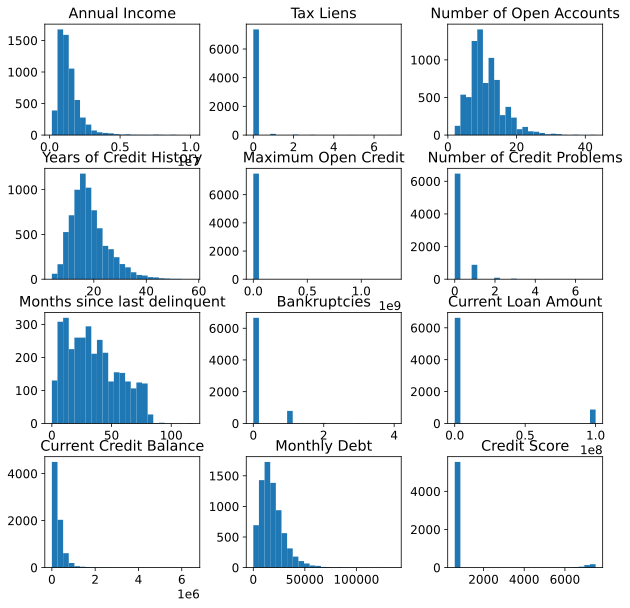

In [10]:
df_train_before_prep.select_dtypes(include='float64').hist(figsize=(10,10), bins=25, grid=False, log=False)

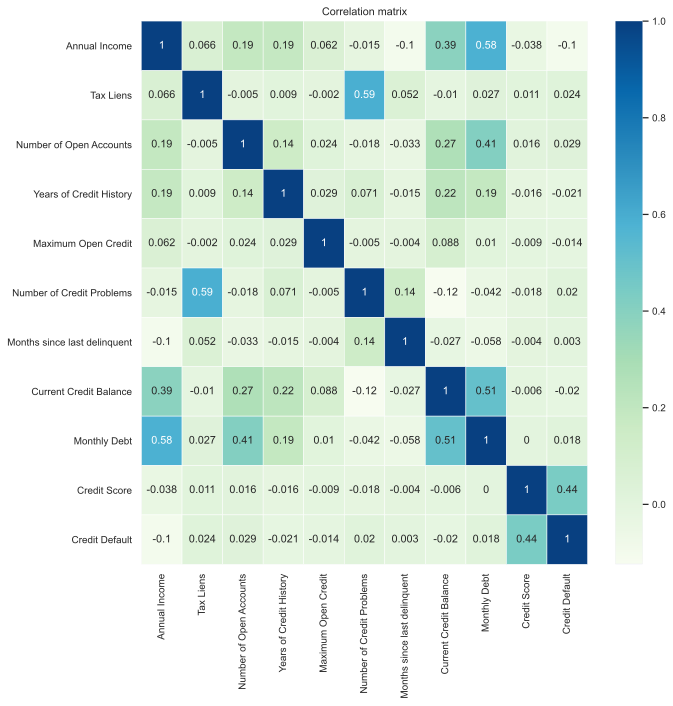

In [11]:
plt.figure(figsize = (10,10))

sns.set(font_scale=0.9)
sns.heatmap(df_train_before_prep[NUM_FEATURE_NAMES + [TARGET_NAME]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

**Что можно сказать по подготовке данных:**
1) Судя по графикам и разнице между 50% и mean можно выделить переменные Maximum Open Credit, Current Loan Amount и Credit Score , которые нуждаются в обработке выбросов. 

2) приведем переменные к бинарному виду
Bankruptcies (0 - нет банкротства, 1 - есть банкроство) 
Tax Liens (0 - нет налоговых обременений, 1 - есть налоговые обременения) 
Number of Credit Problems (0 - нет просрочки по платежу, 1 - есть просрочка по платежу)

3) Annual Income лучше всего коррелирует с Monthly Debt (0.59), поэтому заполним пропуски медианой в соответствии с ним же

4) Наибольшая корреляция целевой переменной наблюдается с переменной Credit Score

5) Обработаем Purpose, разбив на 2 группы наиболее часто встречающихся


## Обработка выбросов/пропусков для train и test датасетов

In [12]:
train_data_preparation = DataPreparation(TRAIN_PATH)
current_loan_amount_median = train_data_preparation.get_loan_amount_median()
default_annual_income = train_data_preparation.get_default_annual_income()
train_df = train_data_preparation.transform(current_loan_amount_median, default_annual_income)

train_df.columns
train_df = train_df[train_data_preparation.add_dummies_columns + NEW_FEATURE_NAMES + NUM_FEATURE_NAMES + [TARGET_NAME]]

test_data_preparation = DataPreparation(TEST_PATH)
test_df = test_data_preparation.transform(current_loan_amount_median, default_annual_income)
test_df = test_df[test_data_preparation.add_dummies_columns + NEW_FEATURE_NAMES + NUM_FEATURE_NAMES]

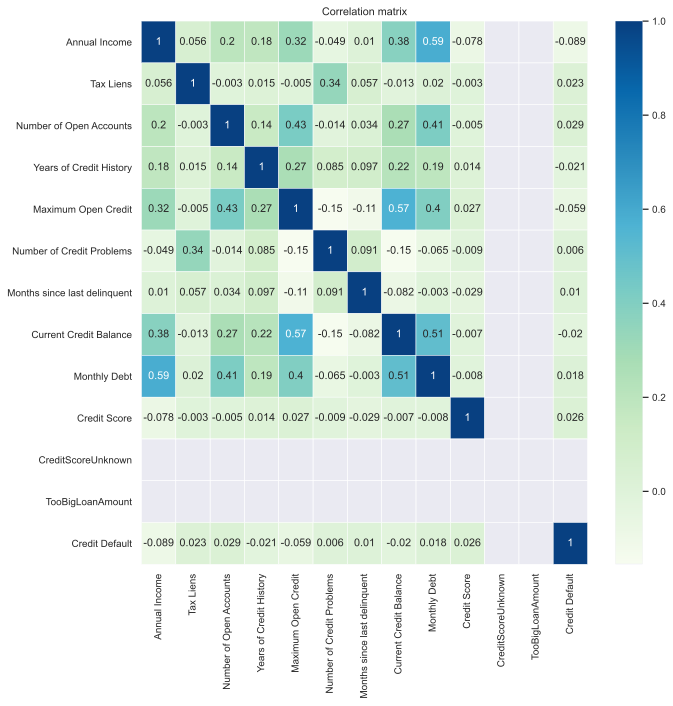

In [13]:
plt.figure(figsize = (10,10))

sns.set(font_scale=0.9)
sns.heatmap(train_df[NUM_FEATURE_NAMES + NEW_FEATURE_NAMES + [TARGET_NAME]].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Финальная модель

In [15]:
teach_model = TeachModel(train_df[train_data_preparation.add_dummies_columns + NUM_FEATURE_NAMES + NEW_FEATURE_NAMES], train_df[TARGET_NAME], TARGET_NAME)
predictions = teach_model.cat_boost(test_df, r_state = 167, n_est = 33, m_depth=3, cw = [1,1.07])

print('TRAIN\n\n' + teach_model.classification_report['train_report'])
print('TEST\n\n' + teach_model.classification_report['test_report'])
print('CONFUSION MATRIX\n')
print(teach_model.classification_report['crosstab'])

TRAIN

              precision    recall  f1-score   support

           0       0.72      0.75      0.73      4271
           1       0.65      0.62      0.63      3308

    accuracy                           0.69      7579
   macro avg       0.68      0.68      0.68      7579
weighted avg       0.69      0.69      0.69      7579

TEST

              precision    recall  f1-score   support

           0       0.79      0.74      0.76      1116
           1       0.45      0.52      0.48       459

    accuracy                           0.67      1575
   macro avg       0.62      0.63      0.62      1575
weighted avg       0.69      0.67      0.68      1575

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               821  295
1               221  238


In [16]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

**Важность признаков**

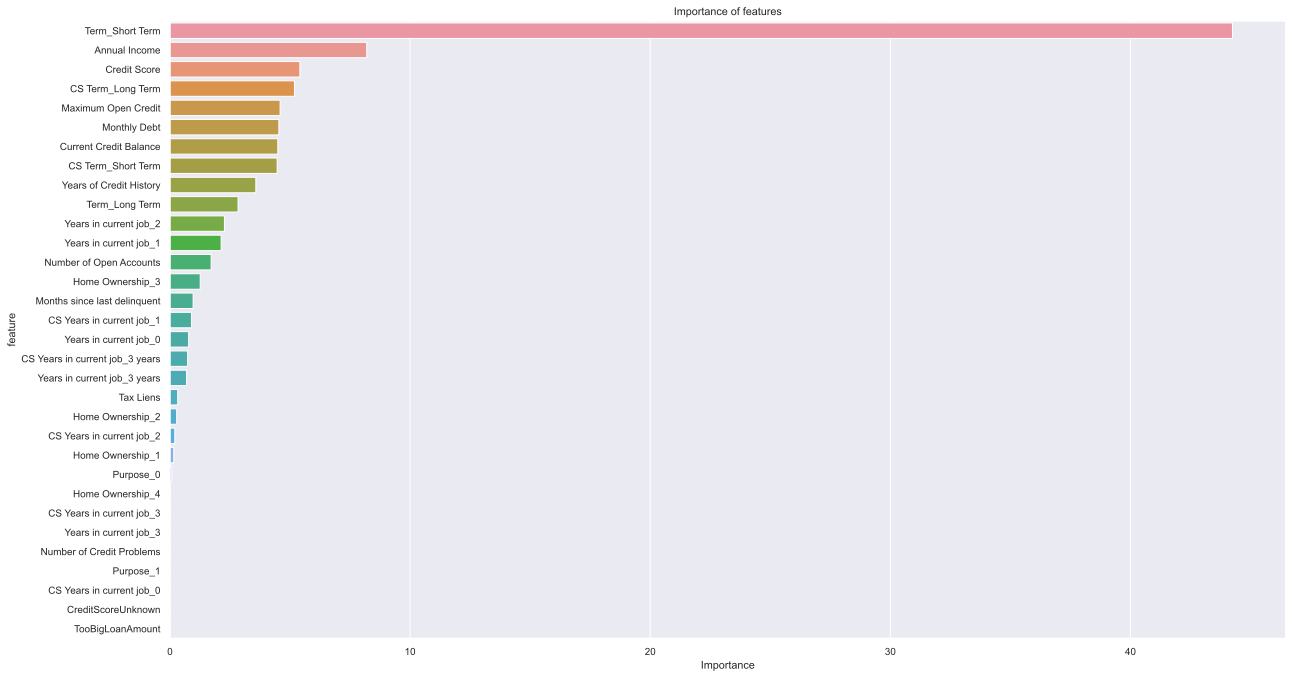

In [17]:
important_features_top = show_feature_importances(teach_model.X_train.columns, teach_model.model.feature_importances_, get_top=15)

## Прогноз

In [18]:
result = pd.DataFrame(index=range(0, len(test_df.index)), columns=['Id', 'Credit Default'])
result['Id'] = list(test_df.index)
result['Credit Default'] = predictions
result.to_csv('Million_predictions.csv', index=False)
result

,Id,Credit Default
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2495,2495,0
2496,2496,1
2497,2497,0
2498,2498,0


## Сохранение модели

In [19]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(teach_model, file)